# Flight Price Prediction 
### Group - 17 (Sahithi Nallani, Srivatsav Busi ) ###
Problem Statement: Finding the ideal number of days left to book a flight ticket

Air travel takes the top spot when time is a major constraint for the duration of travel which impacts the ticket fare. One of the most impactful parameters which affects the ticket prices is the booking time. All of us want to book the lowest possible ticket fare, we neither want to book the ticket very early and block our money nor we want to wait till the last moment and and pay a hefty price. Hence, in our project, we want to find the ideal number of days left from the date of travel before which we can book our tickets. In addition to the above mentioned, we would also like to understand the impact of different attributes on the price of the ticket.

Dataset Overview:

Ticket booking information for tickets booked on 10th Feb, 2022 for date of travel ranging from 11th Feb, 2022 and 31st March, 2022. Dataset is based on domestic flight tickets across various cities in India.

https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?datasetId=1957837&sortBy=voteCount

Size : 300k ( Economy + Business) Attributes : Airline, Flight, Source, Destination, Dep Time, Arrival Time, Stops, Duration, Price

Importing kaggle library to download the kaggle dataset

In [0]:
!pip install kaggle

     |████████████████████████████████| 63 kB 578 kB/s 
     |████████████████████████████████| 77 kB 4.0 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77734 sha256=f408afe23d519718fd8cd070632c96abd110958126dae86ed7b16f02fbbf422a
  Stored in directory: /root/.cache/pip/wheels/9c/45/15/6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763
Successfully built kaggle
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7a3fc130-92ef-44b7-a35e-6dbb100e26e1/bin/python -m pip install --upgrade pip' command.


Store Kaggle API key on file system to download dataset from Kaggle. Unzip the downloaded files.

In [0]:
%sh
mkdir -p /root/.kaggle
echo '{"username":"hemanthkumarenuguri","key":"4b8d25439d118a158d764a8be96ff204"}' > /root/.kaggle/kaggle.json
kaggle datasets download -d shubhambathwal/flight-price-prediction
unzip flight-price-prediction.zip


  0%|          | 0.00/4.16M [00:00<?, ?B/s]
100%|██████████| 4.16M/4.16M [00:00<00:00, 55.3MB/s]

Archive:  flight-price-prediction.zip
  inflating: Clean_Dataset.csv       
  inflating: business.csv            
  inflating: economy.csv             


The dataset consists of 300261 records & 11 attributes

Now, splitting the data into economy and business classes and putted them into separate dataframes. This is done because there is a lot of price difference between economy and business classes and we want to understand the impact of the attributes on these prices separately. 

In [0]:
economy_df = spark.read.csv('file:/databricks/driver/economy.csv', inferSchema=True, header=True, escape='"', quote='"', multiLine=True)
economy_df.cache()
economy_df.show(5)

+----------+--------+-------+--------+-------------------+-----+----------+---------+-------------------+------+-----+
|      date| airline|ch_code|num_code|           dep_time| from|time_taken|     stop|           arr_time|    to|price|
+----------+--------+-------+--------+-------------------+-----+----------+---------+-------------------+------+-----+
|2022-02-11|SpiceJet|     SG|    8709|2023-04-29 18:55:00|Delhi|   02h 10m|non-stop |2023-04-29 21:05:00|Mumbai|5,953|
|2022-02-11|SpiceJet|     SG|    8157|2023-04-29 06:20:00|Delhi|   02h 20m|non-stop |2023-04-29 08:40:00|Mumbai|5,953|
|2022-02-11| AirAsia|     I5|     764|2023-04-29 04:25:00|Delhi|   02h 10m|non-stop |2023-04-29 06:35:00|Mumbai|5,956|
|2022-02-11| Vistara|     UK|     995|2023-04-29 10:20:00|Delhi|   02h 15m|non-stop |2023-04-29 12:35:00|Mumbai|5,955|
|2022-02-11| Vistara|     UK|     963|2023-04-29 08:50:00|Delhi|   02h 20m|non-stop |2023-04-29 11:10:00|Mumbai|5,955|
+----------+--------+-------+--------+----------

In [0]:
business_df = spark.read.csv('file:/databricks/driver/business.csv', inferSchema=True, header=True, escape='"', quote='"', multiLine=True)
business_df.cache()
business_df.show(5)

+----------+---------+-------+--------+-------------------+-----+----------+--------------------+-------------------+------+------+
|      date|  airline|ch_code|num_code|           dep_time| from|time_taken|                stop|           arr_time|    to| price|
+----------+---------+-------+--------+-------------------+-----+----------+--------------------+-------------------+------+------+
|2022-02-11|Air India|     AI|     868|2023-04-29 18:00:00|Delhi|   02h 00m|           non-stop |2023-04-29 20:00:00|Mumbai|25,612|
|2022-02-11|Air India|     AI|     624|2023-04-29 19:00:00|Delhi|   02h 15m|           non-stop |2023-04-29 21:15:00|Mumbai|25,612|
|2022-02-11|Air India|     AI|     531|2023-04-29 20:00:00|Delhi|   24h 45m|1-stop\n\t\t\t\t\...|2023-04-29 20:45:00|Mumbai|42,220|
|2022-02-11|Air India|     AI|     839|2023-04-29 21:25:00|Delhi|   26h 30m|1-stop\n\t\t\t\t\...|2023-04-29 23:55:00|Mumbai|44,450|
|2022-02-11|Air India|     AI|     544|2023-04-29 17:15:00|Delhi|   06h 40m|

Add a column to differntiate the economy or business class ticket.

In [0]:
import pyspark.sql.functions as F
economy_df = economy_df.withColumn('class',F.lit('economy'))
business_df = business_df.withColumn('class',F.lit('business'))

Here, we are joining both the economy and business dataframes and showing the first 10 rows. Some notable columns here are "Name of the airline", "Time taken", "Number of Stops" and "Price"

In [0]:
flight_data = economy_df.union(business_df)
flight_data.cache()
flight_data.show(5)

+----------+--------+-------+--------+-------------------+-----+----------+---------+-------------------+------+-----+-------+
|      date| airline|ch_code|num_code|           dep_time| from|time_taken|     stop|           arr_time|    to|price|  class|
+----------+--------+-------+--------+-------------------+-----+----------+---------+-------------------+------+-----+-------+
|2022-02-11|SpiceJet|     SG|    8709|2023-04-29 18:55:00|Delhi|   02h 10m|non-stop |2023-04-29 21:05:00|Mumbai|5,953|economy|
|2022-02-11|SpiceJet|     SG|    8157|2023-04-29 06:20:00|Delhi|   02h 20m|non-stop |2023-04-29 08:40:00|Mumbai|5,953|economy|
|2022-02-11| AirAsia|     I5|     764|2023-04-29 04:25:00|Delhi|   02h 10m|non-stop |2023-04-29 06:35:00|Mumbai|5,956|economy|
|2022-02-11| Vistara|     UK|     995|2023-04-29 10:20:00|Delhi|   02h 15m|non-stop |2023-04-29 12:35:00|Mumbai|5,955|economy|
|2022-02-11| Vistara|     UK|     963|2023-04-29 08:50:00|Delhi|   02h 20m|non-stop |2023-04-29 11:10:00|Mumbai

It's important to **unpersist** objects stored in memory if we no longer use them. This makes a lot of impact if we have large dataframes and a long lineage of operations on same dataframe.

In [0]:
economy_df.unpersist()
business_df.unpersist()

Out[7]: DataFrame[date: date, airline: string, ch_code: string, num_code: int, dep_time: timestamp, from: string, time_taken: string, stop: string, arr_time: timestamp, to: string, price: string, class: string]

# Data Cleaning 
Deriving the flight code from attributes num_code and ch_code, which individually do not add much value.

In [0]:
flight_data = flight_data.withColumn("num_code", flight_data["num_code"].cast("string"))
flight_data = flight_data.withColumn("flight", F.concat_ws("-", flight_data["ch_code"], flight_data["num_code"]))
flight_data = flight_data.drop("ch_code", "num_code")

Here, we are renaming the columns to be more appealing

In [0]:
flight_data = flight_data.withColumnRenamed("dep_time", "departure_time") \
                         .withColumnRenamed("from", "source_city") \
                         .withColumnRenamed("time_taken", "duration") \
                         .withColumnRenamed("stop", "stops") \
                         .withColumnRenamed("arr_time", "arrival_time") \
                         .withColumnRenamed("to", "destination_city")

Now, deriving the days left for travel from a static booking date and travel date (As mentioned in the beginning, ticket booking information is for tickets booked on 10th Feb, 2022 for date of travel ranging from 11th Feb, 2022 and 31st March, 2022.) 

In [0]:
flight_data = flight_data.withColumn("date", F.to_date("date", "dd-MM-yyyy"))
flight_data = flight_data.withColumn("days_left", F.datediff( "date", F.lit("2022-02-10")))
flight_data.show(2)

+----------+--------+-------------------+-----------+--------+---------+-------------------+----------------+-----+-------+-------+---------+
|      date| airline|     departure_time|source_city|duration|    stops|       arrival_time|destination_city|price|  class| flight|days_left|
+----------+--------+-------------------+-----------+--------+---------+-------------------+----------------+-----+-------+-------+---------+
|2022-02-11|SpiceJet|2023-04-29 18:55:00|      Delhi| 02h 10m|non-stop |2023-04-29 21:05:00|          Mumbai|5,953|economy|SG-8709|        1|
|2022-02-11|SpiceJet|2023-04-29 06:20:00|      Delhi| 02h 20m|non-stop |2023-04-29 08:40:00|          Mumbai|5,953|economy|SG-8157|        1|
+----------+--------+-------------------+-----------+--------+---------+-------------------+----------------+-----+-------+-------+---------+
only showing top 2 rows



In [0]:
flight_data = flight_data.drop("date")

Converting the travel time of day into 6 bins according to time of day for both departure and arrival times. Starting from 'late night' which is from 12am to 4am, we have named the next 4 hours as 'Early Morning', subsequent 4 hours as 'Morning' and so on and so forth

In [0]:
from pyspark.sql.functions import when
flight_data = flight_data.withColumn("departure_slot",  F.floor(F.hour(F.col("departure_time")) / 4)+1)\
.withColumn("departure_time", when(F.col("departure_slot") == 1, "Late Night")\
           .when(F.col("departure_slot") == 2, "Early Morning")\
           .when(F.col("departure_slot") == 3, "Morning")\
           .when(F.col("departure_slot") == 4, "Afternoon")\
           .when(F.col("departure_slot") == 5, "Evening")\
           .when(F.col("departure_slot") == 6, "Night"))\
           .drop("departure_slot")
flight_data = flight_data.withColumn("arrival_slot",  F.floor(F.hour(F.col("arrival_time")) / 4)+1)\
.withColumn("arrival_time", when(F.col("arrival_slot") == 1, "Late Night")\
           .when(F.col("arrival_slot") == 2, "Early Morning")\
           .when(F.col("arrival_slot") == 3, "Morning")\
           .when(F.col("arrival_slot") == 4, "Afternoon")\
           .when(F.col("arrival_slot") == 5, "Evening")\
           .when(F.col("arrival_slot") == 6, "Night"))\
           .drop("arrival_slot")

In [0]:
flight_data.show(2)

+--------+--------------+-----------+--------+---------+------------+----------------+-----+-------+-------+---------+
| airline|departure_time|source_city|duration|    stops|arrival_time|destination_city|price|  class| flight|days_left|
+--------+--------------+-----------+--------+---------+------------+----------------+-----+-------+-------+---------+
|SpiceJet|       Evening|      Delhi| 02h 10m|non-stop |       Night|          Mumbai|5,953|economy|SG-8709|        1|
|SpiceJet| Early Morning|      Delhi| 02h 20m|non-stop |     Morning|          Mumbai|5,953|economy|SG-8157|        1|
+--------+--------------+-----------+--------+---------+------------+----------------+-----+-------+-------+---------+
only showing top 2 rows



Initial duration is in hr and min format, which is being converted to minutes for ease of analysis.

In [0]:
from pyspark.sql.functions import split, col, regexp_replace
flight_data = flight_data.withColumn('temp',split(col("duration"), " "))\
            .withColumn("hours", regexp_replace(col("temp")[0], "[^0-9]+", "").cast("int"))\
            .withColumn("minutes", when(col("temp")[1] == "", 0).otherwise(regexp_replace(col("temp")[1], "[^0-9]+", "")).cast("int"))\
            .withColumn("duration",col("duration").cast("int"))\
            .withColumn("duration",  (col("hours") * 60) + col("minutes"))\
            .drop("temp","hours","minutes")

Stops information is available as a string currently, we are extracting the number of stops from string.

In [0]:
flight_data = flight_data.withColumn("stops", regexp_replace("stops", "[^0-9]", "")) \
                         .withColumn("stops", when(col("stops") == "", 0).otherwise(col("stops"))) \
                         .withColumn("stops", col("stops").cast("int"))

The price information is present in string format and is being extracted as an integer.

In [0]:
flight_data = flight_data.withColumn("price", regexp_replace("price", "[^0-9]", "")) \
                         .withColumn("price", col("price").cast("int"))

In [0]:
import pyspark.sql.functions as F
null_counts = flight_data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in flight_data.columns]).collect()

# Display the null counts
for row in null_counts:
    print(row)

Row(airline=0, departure_time=0, source_city=0, duration=4, stops=0, arrival_time=0, destination_city=0, price=0, class=0, flight=0, days_left=0)


we are dropping the **nulls** present in the duration column.

In [0]:
flight_data = flight_data.dropna()

# Analysis and Visualization


We are showing the first 5 rows of the cleaned dataset which is now ready for data analysis and visualizations

In [0]:
flight_data.show(5)

+--------+--------------+-----------+--------+-----+-------------+----------------+-----+-------+-------+---------+
| airline|departure_time|source_city|duration|stops| arrival_time|destination_city|price|  class| flight|days_left|
+--------+--------------+-----------+--------+-----+-------------+----------------+-----+-------+-------+---------+
|SpiceJet|       Evening|      Delhi|     130|    0|        Night|          Mumbai| 5953|economy|SG-8709|        1|
|SpiceJet| Early Morning|      Delhi|     140|    0|      Morning|          Mumbai| 5953|economy|SG-8157|        1|
| AirAsia| Early Morning|      Delhi|     130|    0|Early Morning|          Mumbai| 5956|economy| I5-764|        1|
| Vistara|       Morning|      Delhi|     135|    0|    Afternoon|          Mumbai| 5955|economy| UK-995|        1|
| Vistara|       Morning|      Delhi|     140|    0|      Morning|          Mumbai| 5955|economy| UK-963|        1|
+--------+--------------+-----------+--------+-----+-------------+------

Now, we wanted to see whether there is any correlation between the number of days left and the ticket price which is our main point of analysis. As we can see below, for economy class, the correlation of days left for travel and the price is inversely proportional (-0.55) i.e price increases when number of days left for travel is less

In [0]:
from pyspark.sql.functions import corr
corr_value = flight_data.filter(col("class")=="economy").select(corr('days_left', 'price')).collect()[0][0]
print("Correlation between days_left and price is: ", corr_value)


Correlation between days_left and price is:  -0.5593346751336754


But for Business class, Impact of days left to travel on price is **less** i.e., correlation is close to 0 (-0.09)

In [0]:
from pyspark.sql.functions import corr
corr_value = flight_data.filter(col("class")=="business").select(corr('days_left', 'price')).collect()[0][0]
print("Correlation between days_left and price is: ", corr_value)

Correlation between days_left and price is:  -0.09128941558253949


Now, we are converting our existing PySpark dataframes into Pandas dataframes for data visualization purpose

In [0]:
economy_df_pandas = flight_data.filter(col("class")=="economy").toPandas()
business_df_pandas = flight_data.filter(col("class")=="business").toPandas()
flight_data_pandas = flight_data.toPandas()

Importing the required Pandas libraries for visualization.

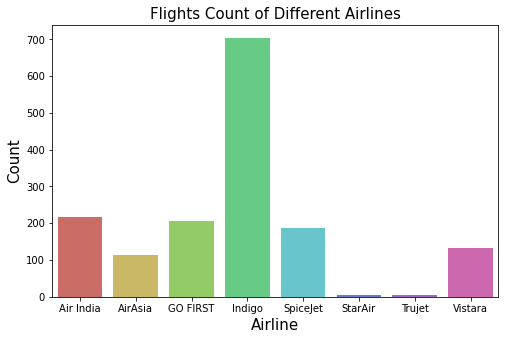

In [0]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time, datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)


df1=flight_data_pandas.groupby(['airline','flight'],as_index=False).count()
df1['airline'].value_counts()

plt.figure(figsize=(8,5))
sns.countplot(df1['airline'],palette='hls')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

The graph above shows the count of different airlines in our dataset. As we can see, Indigo has the most number of flights followed by Air India and Go First, while Star Air and Trujet have the least

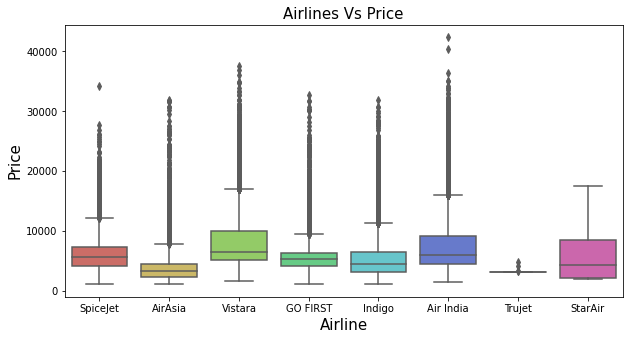

In [0]:
plt.figure(figsize=(10,5))
sns.boxplot(x=economy_df_pandas['airline'],y=flight_data_pandas['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

The graph above shows the comparison of Airline and Price for the economy class in different airlines. We can observe that the price range is almost similar in all the airlines except for Vistara and Air India which have a greater price range compared to the others

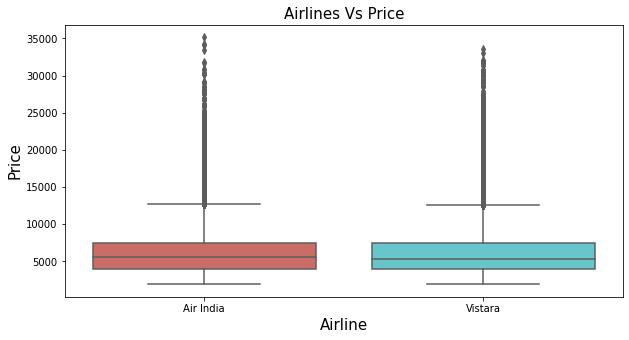

In [0]:
plt.figure(figsize=(10,5))
sns.boxplot(x=business_df_pandas['airline'],y=flight_data_pandas['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

The graph above shows the comparison of Airline and Price for the business class. One interesting fact here is that, only Vistara and Air India offer business class services and both have a similar price range

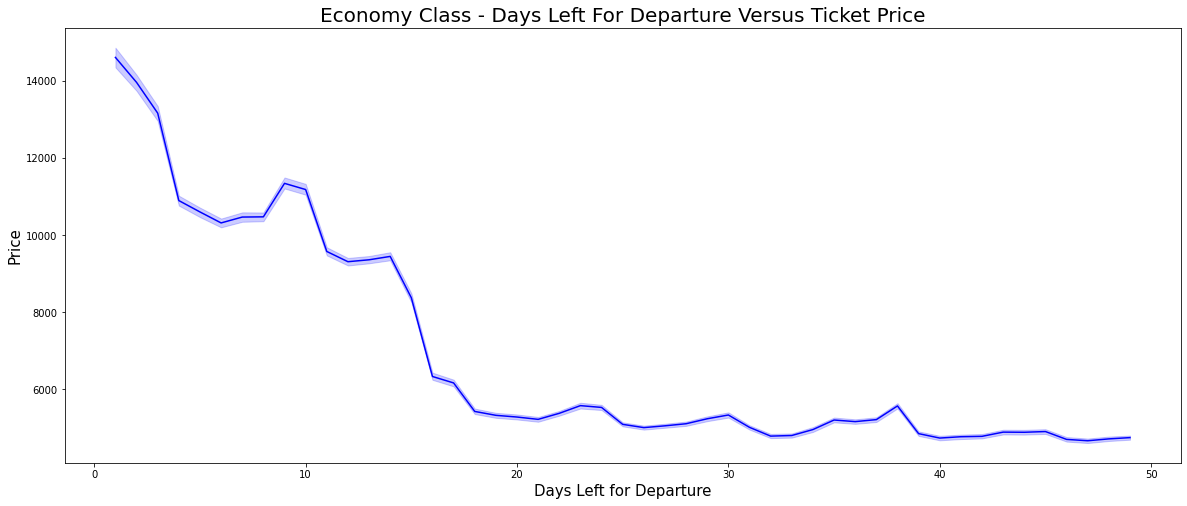

In [0]:
plt.figure(figsize=(20,8))
sns.lineplot(data=economy_df_pandas,x='days_left',y='price',color='blue')
plt.title('Economy Class - Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

The graph above shows the relation between 'Days left for Departure' and 'Price' for the economy class. We can infer that the prices are more when the days left for departure are less and the prices reduce as there are more days left for departure, but at around 20 days left for departure, the graph straightens and the price is more or less same even if the days left for departure are more. So, we can infer from this initial analysis, that the ideal day to book economy class flight tickets would be around 20th day prior the day of travel. We would like to further our analysis to business class and overall as well in our final project report.

## ML Model


Split the dataset as test and train into 60 and 40 with a randomisation of 24.

In [0]:
train_data, test_data  = flight_data.randomSplit([0.6, 0.4], 24)   # proportions [], seed for random

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 180205
Number of testing records : 120052


In [0]:
from pyspark.ml.feature import VectorAssembler,RFormula
featuresCols = ['departure_time','source_city', 'duration', 'stops' , 'destination_city', 'class', 'days_left'  ]
formula = "{} ~ {}".format("price", " + ".join(featuresCols))
print("Formula : {}".format(formula))
rformula = RFormula(formula = formula)

Formula : price ~ departure_time + source_city + duration + stops + destination_city + class + days_left


#Linear Regression


In [0]:
from pyspark.ml.regression import LinearRegression
 
lr = LinearRegression(labelCol="price")

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
 
# Define a grid of hyperparameters to test:
#  - maxDepth: maximum depth of each decision tree 
#  - maxIter: iterations, or the total number of trees 
paramGrid = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 20]) \
  .build()
 
# Define two metrics for regression
rmse = RegressionEvaluator(metricName="rmse", labelCol=lr.getLabelCol(), predictionCol=lr.getPredictionCol())
r2 = RegressionEvaluator(metricName="r2", labelCol=lr.getLabelCol(), predictionCol=lr.getPredictionCol())
 
cv = CrossValidator(estimator=lr, evaluator=r2, estimatorParamMaps=paramGrid)

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[rformula, cv])

In [0]:
pipelineModel = pipeline.fit(train_data)

In [0]:
lm = pipelineModel.stages[1].bestModel

# Summaries

## Training Summary

In [0]:
lm.summary
lm.summary.r2

Out[66]: 0.9034712506072022

Training Summary: Model coefficient, intercept (like R)


In [0]:
import pyspark.sql.functions as F

x_cols = featuresCols

# Nice summary here: https://www.learnbymarketing.com/tutorials/explaining-the-lm-summary-in-r
def f_stats(residuals, num_coefficients):
  sse = residuals.withColumn('res_sq', residuals.residual * residuals.residual).agg(F.sum('res_sq').alias('SSE')).collect()[0]['SSE']
  y_mean = residuals.agg(F.mean('prediction').alias('y_mean')).collect()[0]['y_mean']
  SSyy = residuals.withColumn('mean_diff', (residuals.prediction - y_mean) * (residuals.prediction - y_mean)).agg(F.sum('mean_diff').alias('SSyy')).collect()[0]['SSyy']
  n = residuals.count()
  res_std_err = (sse / (n - (num_coefficients+1)))
  f_stat = ((SSyy - sse) / num_coefficients) / (sse / (n - (num_coefficients+1)))
  return res_std_err, f_stat

def residuals_summary(lm, data):
  lm_results = pipelineModel.transform(data)
  labeled_predictions = lm_results.select(lm.summary.labelCol, lm.summary.predictionCol)
  residuals = labeled_predictions.withColumn('residual', labeled_predictions[lm.summary.labelCol] - labeled_predictions[lm.summary.predictionCol])
  res_summary = residuals.summary().select('residual')
  res_vals = [res_summary.collect()[3]['residual'], res_summary.collect()[4]['residual'], res_summary.collect()[5]['residual'], res_summary.collect()[6]['residual'], res_summary.collect()[7]['residual']]
  res_labels = ['Min', '1Q', 'Median', '3Q', 'Max']
  print("Rediduals:")
  print(''.join([f"{l:>15}" for l in res_labels]))
  print(''.join([f"{float(l):>15,.3f}" for l in res_vals]))
  return residuals

def lm_summary(lm, formula, columns, lm_summary=None, data=None):
  """
  Print a regression summary similar to that provided by R.
  """  
  if not lm_summary:
    lm_summary = lm.summary  
  try:
    coefficients, coefficientStandardErrors, tValues, pValues = lm.coefficients, lm_summary.coefficientStandardErrors, lm_summary.tValues, lm_summary.pValues
  except Exception:    
    coefficients, coefficientStandardErrors, tValues, pValues = [0.0] * len(columns), [0.0] * len(columns), [0.0] * len(columns), [0.0] * len(columns)
  if data:
    residuals = residuals_summary(lm, data)
    
  equation = ' + '.join([f"{p[0]:,.1f} * {p[1]:<12.12}" for p in zip(coefficients, columns)]) + f"+ {lm.intercept:,.1f}"
  print(f"Formula\n\t{formula}")
  print(f"Equation\n\t{equation}")
  print("Coefficients:")
  print(f"{'': <25.25} {'Estimate': ^25.25} {'Std.Error': ^20} {'t value': ^20} {'Pr(>|t|': ^20}")
  print(f"{'(Intercept)': <25.25} {lm.intercept: >20,.3f}")
  values = zip(columns, coefficients, coefficientStandardErrors, tValues, pValues)
  for p in values:
    print(f"{p[0]: <25.25} {p[1]: >20,.3f} {p[2]: >20,.3f} {p[3]: >20,.3f} {p[4]: >20,.3f}")
  print(f"Root mean squared error (RMSE): {lm_summary.rootMeanSquaredError:,.3f} on {lm_summary.degreesOfFreedom:,} degrees of freedom")
  print(f"Multiple R-squared: {lm_summary.r2:.4f}, Adjusted R-squared: {lm_summary.r2adj:.4f}")
  if residuals:
    res_err, f_stat = f_stats(residuals, len(columns))
    print(f"Residual standard error: {res_err:,.2f}")
    print(f"F-statistic: {f_stat:,.2f}")
  return residuals
  
residuals = lm_summary(lm, formula, x_cols, data=train_data)

Rediduals:
            Min             1Q         Median             3Q            Max
    -43,185.424     -2,830.223       -254.801      2,935.912     66,206.571
Formula
	price ~ departure_time + source_city + duration + stops + destination_city + class + days_left
Equation
	825.8 * departure_ti + 391.8 * source_city  + 300.5 * duration     + 237.4 * stops        + -116.2 * destination_ + -1,822.1 * class        + -320.5 * days_left   + 49,824.8
Coefficients:
                                  Estimate               Std.Error             t value              Pr(>|t|       
(Intercept)                         49,824.801
departure_time                         825.836              266.895                3.094                0.002
source_city                            391.849              267.174                1.467                0.142
duration                               300.542              267.291                1.124                0.261
stops                                  237.

Apply the model to the training data


In [0]:
lm_results = pipelineModel.transform(train_data)
labeled_predictions = lm_results.select('Price', 'prediction')

pdf = labeled_predictions.toPandas()

Actual vs predicted (training data)


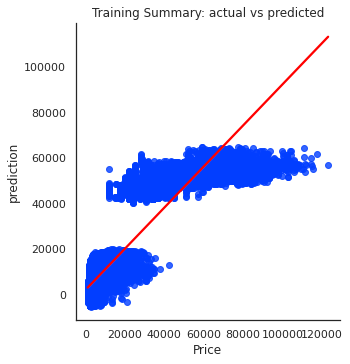

In [0]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

sns.lmplot(data=pdf, x="Price", y="prediction", line_kws={'color': 'red'}, height=5, aspect=1).set(title='Training Summary: actual vs predicted');

Actual vs residuals

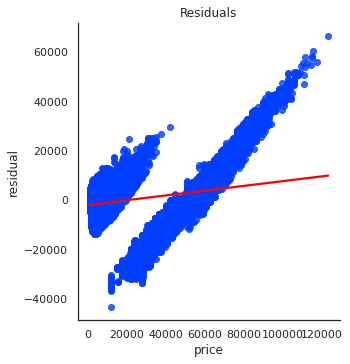

In [0]:
sns.lmplot(data=residuals.toPandas(), x=lm.summary.labelCol, y='residual', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Residuals');

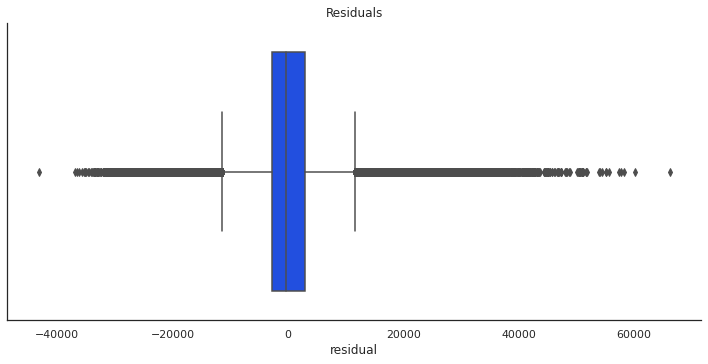

In [0]:
sns.catplot(data=residuals.toPandas(), x='residual', kind='box',  height=5, aspect=2).set(title='Residuals');

# Training vs Testing
* Training produces a model, which is compared with the training data
* The trained model is used for predictions against test data; the model may perform differently than against the training data

## Prediction Summary

Trained model applied to test data

In [0]:
lm_results = pipelineModel.transform(test_data)
labeled_predictions = lm_results.select('Price', 'prediction')

pdf = labeled_predictions.toPandas()

Model fit with test data

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Price")
rmse = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "rmse"})
print(f"Test root mean squared error (RMSE) {rmse:,.4f}")
r2 = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "r2"})
print(f"Test multiple R-squared r2: {r2:,.4f}")
mae = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "mae"})
print(f"Test mean absolute error (MAE): {mae:,.4f}")

# Note: RegressionEvaluator does not have adjusted R-squared (provided by LinearRegressionSummary)

Test root mean squared error (RMSE) 7,020.8695
Test multiple R-squared r2: 0.9042
Test mean absolute error (MAE): 4,597.1704


In [0]:
predictions = pipelineModel.transform(test_data)

Linear regression model has a R2 value of 0.9 i.e 90% close to predicting the actual flight price.

In [0]:
rmse = rmse.evaluate(predictions)

r2 = r2.evaluate(predictions)

print("RMSE on our test set: %g" % rmse)

print("R2 on our test set: %g" % r2)

RMSE on our test set: 7020.87
R2 on our test set: 0.904168


In [0]:
display(predictions.select("price", "prediction"))

price prediction 4491 -868.0924532011559 4491 -1127.406242402627 4491 -1516.3769262048227 4491 -1775.6907154062937 4491 -1905.3476100070257 4491 -2423.9751884099605 4491 -2683.2889776114316 4491 -2812.9458722121635 4491 -2942.6027668128954 7489 1854.7023334142505 8854 947.1040712091199 10534 2373.3299118171853 4491 -3193.192834173795 4491 -3322.8497287745267 1977 8421.877663614934 1977 3365.258774186317 4339 7254.9656122083325 3597 9045.050694784892 3597 7489.167959576087 3597 6581.569697370949 3918 8396.766221781218 5179 10860.24721919516 5179 10211.962746191493 6163 9361.068675950082 6583 8972.097992147887 6583 8194.15662454348 6583 7934.8428353420095 6583 7545.872151539814 6583 7027.244573136879 6583 6378.960100133205 6583 5989.989416331009 7004 9101.754886748618 7004 7675.529046140546 7004 7286.558362338343 7004 6638.273889334676 8198 6767.930783935408 14314 10916.951411158887 15679 9750.039359752285 16099 11435.578989561822 20929 11305.92209496109 13054 16766.621911894537 14419 15859.0236496894 6200 5946.510016447995 6200 5557.5393326457925 6200 4909.254859642126 6200 4779.597965041394 6200 4649.941070440662 6200 3483.029019034053 6620 6076.166911048727 6620 5816.8531218472635 7116 3871.999702836256 7536 6594.7944894516695 13054 8021.020330059735 13054 7761.706540858271 20509 8409.991013861938 14839 12963.092568590248 14839 12833.435673989516 5163 6331.68825759313 11374 7239.286519798268 6578 7563.966564756789 6578 7174.995880954586 6578 6786.02519715239 6578 6526.711407950919 6578 6397.054513350187 6578 6267.397618749455 6578 5878.426934947252 6578 5359.799356544318 6578 5100.4855673428465 6578 4841.171778141383 6893 7434.309670156057 9277 9638.476878368529 9277 9508.819983767797 9277 9379.163089167065 9855 8471.564826961927 11703 10157.104456771463 22189 10027.447562170732 6200 4456.055195043489 6200 3548.4569328383513 6620 6271.251719453765 3685 6289.26858139813 3685 5381.670319192992 3685 4863.042740790057 3685 3825.787583984187 3685 3177.503110980513 4105 5900.297897595927 6047 6548.582370599594 9904 7456.180632804731 15732 8623.092684211333 24604 8493.435789610601 7682 3315.883727421824 12770 6946.276776242368 18560 5131.0802518320925 20135 4353.138884227694 6473 8148.022056964022 6578 7759.051373161827 6578 7240.4237947588845 6578 6981.110005557421 6578 6721.79621635595 6578 6592.139321755218 6578 5943.854848751551 6578 5814.197954150819 6578 5425.227270348616 6578 5165.913481147145 6578 4906.599691945681 6578 4776.942797344949 6893 5554.884164949348 9277 9963.218581374298 9277 9574.247897572095 9277 9444.591002971363 11703 10222.532370575762 11703 9314.934108370631 9362 4102.548816866794 16985 6306.716025079273 22445 4750.833289870468 22445 4491.519500668997 5687 3722.301854905163 7682 4629.900117110301 18650 8260.293165930852 6578 7776.49881684297 6578 7387.528133040774 6578 6868.900554637839 6578 6609.586765436368 6578 6350.2729762349045 6578 5961.3022924327015 6578 5701.98850323123 6578 5572.3316086304985 6578 4924.047135626832 6578 4794.390241026093 6578 4275.762662623165 9277 10369.636708857652 9277 9591.695341253246 9277 9462.038446652514 9277 9073.06776285031 9855 8684.097079048108 9855 8554.440184447376 11703 10239.979814256913 5109 4776.435037128969 5109 3609.5229857223603 5430 4517.121247927498 5844 6332.317772337774 6585 6591.631561539238 8055 5943.347088535571 12844 7499.229823744376 18723 6850.945350740709 6275 6477.8741325515 7325 8293.070656961776 8795 7385.472394756638 3709 5723.797807832656 4024 6631.396070037794 4339 7409.3374376422 6492 10261.789118858338 7752 8446.59259444807 6578 7936.688737885714 6578 7677.374948684243 6578 7418.061159482779 6578 6510.462897277641 6578 5862.178424273974 6578 5732.521529673235 9277 9751.885262295982 9277 9103.600789292315 6583 7711.622866510705 6583 7063.338393507031 6583 6544.710815104096 6583 6285.397025902632 6583 5507.455658298226 7004 9008.191812518038 7004 8878.534917917306 7004 8359.907339514371 7004 8230.25044491364 7004 6804.024604305567 7004 6415.053

The different cluster of points around the line depict the business and economy class sections. It appears that economy class has better prediction compared to business class considering the spread of points around line.

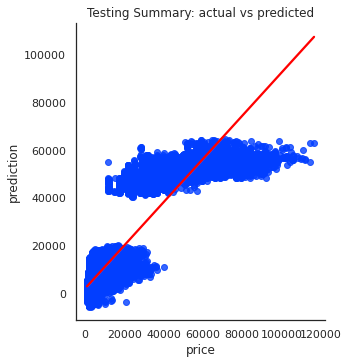

In [0]:
# From Spark to Pandas
pdf = predictions.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt   #Data visualisation libraries 
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")


sns.lmplot(data=pdf, x='price', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Testing Summary: actual vs predicted');

Actual vs residuals

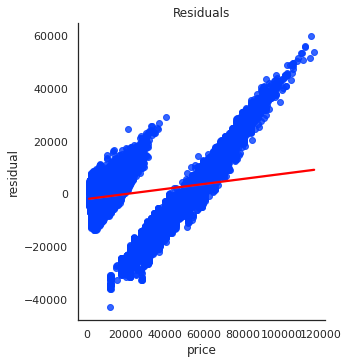

In [0]:
sns.lmplot(data=residuals.toPandas(), x=lm.summary.labelCol, y='residual', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Residuals');

# Regression summary from test data
* Test data is transformed with pipeline prior to Linear Regression
* Apply trained Linear Regression model to transformed test data
* Print Linear Regression summary
  * Empty values for model
  * See summary above for model coefficients (which have not changed with test data)

Prepare test data for input to regression model

In [0]:
rf = RFormula(formula = formula, featuresCol='features')
rff = rf.fit(test_data)
td = rff.transform(test_data)

Regression summary of trained model applied to test data


In [0]:
lm_eval = lm.evaluate(td)
lm_eval

Out[82]: <pyspark.ml.regression.LinearRegressionSummary at 0x7fdde098f6d0>

Testing Summary: model from training data applied to test data

In [0]:
residuals = lm_summary(lm, formula, x_cols, lm_summary=lm_eval, data=test_data);

Rediduals:
            Min             1Q         Median             3Q            Max
    -42,926.110     -2,836.813       -255.906      2,953.358     59,856.982
Formula
	price ~ departure_time + source_city + duration + stops + destination_city + class + days_left
Equation
	0.0 * departure_ti + 0.0 * source_city  + 0.0 * duration     + 0.0 * stops        + 0.0 * destination_ + 0.0 * class        + 0.0 * days_left   + 49,824.8
Coefficients:
                                  Estimate               Std.Error             t value              Pr(>|t|       
(Intercept)                         49,824.801
departure_time                           0.000                0.000                0.000                0.000
source_city                              0.000                0.000                0.000                0.000
duration                                 0.000                0.000                0.000                0.000
stops                                    0.000                

# Random Forest Regressor

In [0]:
from pyspark.ml.regression import RandomForestRegressor
 
rf = RandomForestRegressor(labelCol="price")

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

RandomForest_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

rf_rmse = RegressionEvaluator(metricName="rmse", labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol())
rf_r2 = RegressionEvaluator(metricName="r2", labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol())
 
rf_cv = CrossValidator(estimator=rf, evaluator=rf_rmse, estimatorParamMaps=RandomForest_paramGrid)

In [0]:
from pyspark.ml import Pipeline
rf_pipeline = Pipeline(stages=[rformula, rf_cv])

In [0]:
rf_pipelineModel = rf_pipeline.fit(train_data)

In [0]:
rf_bestmodel = rf_pipelineModel.stages[1].bestModel

In [0]:
rf_pipelineModel.stages[1].bestModel.trees[1].toDebugString

Out[102]: 'DecisionTreeRegressionModel: uid=dtr_029858103c79, depth=10, numNodes=1283, numFeatures=19\n  If (feature 11 <= 0.5)\n   If (feature 10 <= 117.5)\n    If (feature 0 in {0.0})\n     If (feature 6 in {0.0})\n      If (feature 18 <= 16.5)\n       If (feature 17 in {1.0})\n        If (feature 18 <= 3.5)\n         If (feature 1 in {0.0})\n          If (feature 7 in {1.0})\n           Predict: 5155.9375\n          Else (feature 7 not in {1.0})\n           If (feature 12 in {0.0})\n            Predict: 6507.739130434783\n           Else (feature 12 not in {0.0})\n            Predict: 6994.333333333333\n         Else (feature 1 not in {0.0})\n          If (feature 16 in {1.0})\n           Predict: 6506.4375\n          Else (feature 16 not in {1.0})\n           If (feature 12 in {0.0})\n            Predict: 9661.48\n           Else (feature 12 not in {0.0})\n            Predict: 10306.222222222223\n        Else (feature 18 > 3.5)\n         If (feature 3 in {1.0})\n          If (featu

In [0]:
rf_predictions = rf_pipelineModel.transform(test_data)

# Summaries

Apply the model to the training data

In [0]:
rf_results = rf_pipelineModel.transform(train_data)
labeled_predictions = rf_results.select('Price', 'prediction')

pdf = labeled_predictions.toPandas()

Actual vs predicted (training data)

In [0]:
pdf

Price 
 prediction 
 
 
 
 
 0 
 4071 
 4403.429463 
 
 
 1 
 4491 
 4403.429463 
 
 
 2 
 4491 
 4403.429463 
 
 
 3 
 4491 
 4403.429463 
 
 
 4 
 4491 
 4403.429463 
 
 
 ... 
 ... 
 ... 
 
 
 180200 
 76000 
 64881.820612 
 
 
 180201 
 82317 
 58241.984042 
 
 
 180202 
 80077 
 61620.056132 
 
 
 180203 
 92772 
 64881.820612 
 
 
 180204 
 82989 
 62436.506633 
 
 
 
 180205 rows × 2 columns

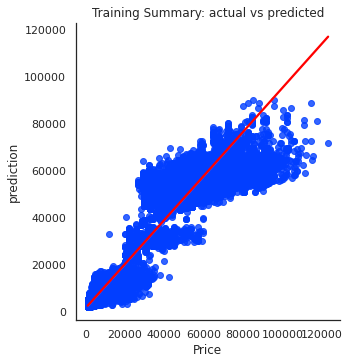

In [0]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

sns.lmplot(data=pdf, x='Price', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Training Summary: actual vs predicted');

# Training vs Testing
* Training produces a model, which is compared with the training data
* The trained model is used for predictions against test data; the model may perform differently than against the training data

## Prediction Summary

In [0]:
rf_results = rf_pipelineModel.transform(test_data)
labeled_predictions = rf_results.select('Price', 'prediction')

pdf = labeled_predictions.toPandas()

Model fit with test data

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Price")
rmse = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "rmse"})
print(f"Test root mean squared error (RMSE) {rmse:,.4f}")
r2 = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "r2"})
print(f"Test multiple R-squared r2: {r2:,.4f}")
mae = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "mae"})
print(f"Test mean absolute error (MAE): {mae:,.4f}")


Test root mean squared error (RMSE) 5,157.5924
Test multiple R-squared r2: 0.9483
Test mean absolute error (MAE): 3,078.3461


In [0]:
display(labeled_predictions.select("price", "prediction"))

price prediction 4491 4403.429462736389 4491 4403.429462736389 4491 4401.751706516347 4491 4401.751706516347 4491 4401.751706516347 4491 4437.5820603074335 4491 4437.5820603074335 4491 4437.5820603074335 4491 4437.5820603074335 7489 8243.283784673275 8854 7790.791357136404 10534 9789.492733370225 4491 4437.5820603074335 4491 4437.5820603074335 1977 8446.192624911257 1977 3587.7231633019437 4339 7030.326717437643 3597 5218.991636226551 3597 5103.069107353222 3597 4530.044616924184 3918 5218.991636226551 5179 9242.29882236333 5179 8390.780265431174 6163 5354.472605044817 6583 5296.372226427333 6583 5296.372226427333 6583 5296.372226427333 6583 5268.263608984562 6583 5268.263608984562 6583 4657.388681790167 6583 4657.388681790167 7004 5296.372226427333 7004 5268.263608984562 7004 5268.263608984562 7004 4657.388681790167 8198 5268.263608984562 14314 9873.40310486629 15679 7122.405523492678 16099 11894.209305016968 20929 11894.209305016968 13054 12686.000293909732 14419 10350.805096472775 6200 4842.3654152621875 6200 4842.3654152621875 6200 4842.3654152621875 6200 4842.3654152621875 6200 4842.3654152621875 6200 4376.39898123425 6620 4842.3654152621875 6620 4842.3654152621875 7116 4842.3654152621875 7536 5546.814741317549 13054 9696.95630781262 13054 9696.95630781262 20509 12596.369403733484 14839 11357.35973917628 14839 9596.194726714975 5163 4905.426654131707 11374 9032.877940825632 6578 4935.591914060481 6578 4935.591914060481 6578 4935.591914060481 6578 4935.591914060481 6578 4935.591914060481 6578 4935.591914060481 6578 4935.591914060481 6578 4515.900934753111 6578 4515.900934753111 6578 4515.900934753111 6893 4935.591914060481 9277 10051.683157235035 9277 10102.765501570057 9277 10102.765501570057 9855 7089.620407553538 11703 12983.792961658144 22189 12983.792961658144 6200 4842.3654152621875 6200 4376.39898123425 6620 4842.3654152621875 3685 4905.426654131707 3685 4905.426654131707 3685 4905.426654131707 3685 4503.258332642588 3685 4503.258332642588 4105 4905.426654131707 6047 4905.426654131707 9904 9279.908267840085 15732 13017.96918382569 24604 13017.96918382569 7682 4750.466494537402 12770 7175.936356893062 18560 5011.60456977254 20135 5011.60456977254 6473 5124.810370687563 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 4763.109096647924 6578 4763.109096647924 6578 4763.109096647924 6578 4763.109096647924 6893 5066.709992070078 9277 10096.698540417634 9277 10147.780884752656 9277 10147.780884752656 11703 13028.808344840743 11703 10258.194580977708 9362 5011.60456977254 16985 5011.60456977254 22445 5011.60456977254 22445 5011.60456977254 5687 4750.466494537402 7682 5011.60456977254 18650 10031.24521339891 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 5066.709992070078 6578 4763.109096647924 6578 4763.109096647924 6578 4797.723595635778 9277 13028.808344840743 9277 10147.780884752656 9277 10147.780884752656 9277 9479.876508944257 9855 9385.705713392852 9855 7312.882815410451 11703 13028.808344840743 5109 5089.250662184847 5109 4820.120613695808 5430 5089.250662184847 5844 5126.629809350141 6585 5177.725822433593 8055 5126.629809350141 12844 9270.690896731303 18723 7145.768518584227 6275 5097.07512801379 7325 7503.04579964941 8795 5134.454275179084 3709 5125.735208602189 4024 5125.735208602189 4339 5163.114355767482 6492 13177.759363368565 7752 7531.705880237809 6578 5163.114355767482 6578 5163.114355767482 6578 5163.114355767482 6578 5125.735208602189 6578 5125.735208602189 6578 5125.735208602189 9277 10389.367264773344 9277 9663.795798040002 6583 5587.78948458604 6583 5587.78948458604 6583 5378.209688049152 6583 5378.209688049152 6583 5495.453872291896 7004 5615.89810202881 7004 5615.89810202881 7004 5615.89810202881 7004 5615.89810202881 7004 5378.209688049152 7004 5378.209688049152 7109

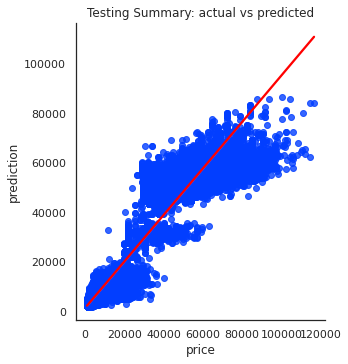

In [0]:
# From Spark to Pandas
pdf = rf_predictions.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt   #Data visualisation libraries 
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")


sns.lmplot(data=pdf, x='price', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Testing Summary: actual vs predicted');

# Decision Tree Regressor

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
 
dt = DecisionTreeRegressor(labelCol="price")

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

DecisionTree_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [32, 64, 128]) \
    .build()

dt_rmse = RegressionEvaluator(metricName="rmse", labelCol=dt.getLabelCol(), predictionCol=dt.getPredictionCol())
dt_r2 = RegressionEvaluator(metricName="r2", labelCol=dt.getLabelCol(), predictionCol=dt.getPredictionCol())
 
dt_cv = CrossValidator(estimator=dt, evaluator=dt_rmse, estimatorParamMaps=DecisionTree_paramGrid)

In [0]:
from pyspark.ml import Pipeline
dt_pipeline = Pipeline(stages=[rformula, dt_cv])

In [0]:
dt_pipelineModel = dt_pipeline.fit(train_data)

In [0]:
dt_bestmodel = dt_pipelineModel.stages[1].bestModel

In [0]:
dt_pipelineModel.stages[1].bestModel.toDebugString

Out[121]: 'DecisionTreeRegressionModel: uid=DecisionTreeRegressor_50cb3434c4d7, depth=10, numNodes=1569, numFeatures=19\n  If (feature 17 in {1.0})\n   If (feature 18 <= 15.5)\n    If (feature 10 <= 257.5)\n     If (feature 10 <= 152.5)\n      If (feature 18 <= 3.5)\n       If (feature 18 <= 1.5)\n        If (feature 10 <= 127.5)\n         If (feature 10 <= 107.5)\n          If (feature 6 in {1.0})\n           If (feature 2 in {0.0})\n            Predict: 6300.3\n           Else (feature 2 not in {0.0})\n            Predict: 9303.0\n          Else (feature 6 not in {1.0})\n           If (feature 2 in {1.0})\n            Predict: 5743.0\n           Else (feature 2 not in {1.0})\n            Predict: 10727.0\n         Else (feature 10 > 107.5)\n          If (feature 10 <= 122.5)\n           If (feature 7 in {1.0})\n            Predict: 10043.333333333334\n           Else (feature 7 not in {1.0})\n            Predict: 14640.0\n          Else (feature 10 > 122.5)\n           If (feature 3 

# Summaries

Apply the model to the training data

In [0]:
dt_results = dt_pipelineModel.transform(train_data)
labeled_predictions = dt_results.select('Price', 'prediction')

pdf = labeled_predictions.toPandas()

Actual vs predicted (training data)

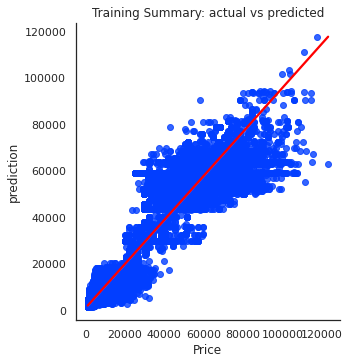

In [0]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")

sns.lmplot(data=pdf, x='Price', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Training Summary: actual vs predicted');

# Training vs Testing
* Training produces a model, which is compared with the training data
* The trained model is used for predictions against test data; the model may perform differently than against the training data

Trained model applied to test data

In [0]:
dt_results = dt_pipelineModel.transform(test_data)
labeled_predictions = dt_results.select('Price', 'prediction')

pdf = labeled_predictions.toPandas()

Model fit with test data

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Price")
rmse = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "rmse"})
print(f"Test root mean squared error (RMSE) {rmse:,.4f}")
r2 = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "r2"})
print(f"Test multiple R-squared r2: {r2:,.4f}")
mae = evaluator.evaluate(labeled_predictions, {evaluator.metricName: "mae"})
print(f"Test mean absolute error (MAE): {mae:,.4f}")

Test root mean squared error (RMSE) 5,294.3542
Test multiple R-squared r2: 0.9455
Test mean absolute error (MAE): 3,100.4469


In [0]:
display(labeled_predictions.select("price", "prediction"))

price prediction 4491 4606.445512820513 4491 4606.445512820513 4491 3872.4452554744526 4491 3872.4452554744526 4491 3872.4452554744526 4491 3872.4452554744526 4491 3872.4452554744526 4491 3872.4452554744526 4491 3872.4452554744526 7489 7178.154471544715 8854 7395.917159763314 10534 10820.09090909091 4491 3872.4452554744526 4491 3872.4452554744526 1977 8362.551724137931 1977 3285.1532258064517 4339 6499.175824175824 3597 5320.352834740652 3597 5320.352834740652 3597 4130.113738738739 3918 5320.352834740652 5179 9988.821958456972 5179 8818.251215559158 6163 5320.352834740652 6583 5320.352834740652 6583 5320.352834740652 6583 5320.352834740652 6583 5320.352834740652 6583 5320.352834740652 6583 4130.113738738739 6583 4130.113738738739 7004 5320.352834740652 7004 5320.352834740652 7004 5320.352834740652 7004 4130.113738738739 8198 5320.352834740652 14314 9988.821958456972 15679 7873.993212669683 16099 12970.424068767908 20929 12970.424068767908 13054 14699.303703703703 14419 8818.251215559158 6200 4628.740395981087 6200 4628.740395981087 6200 4628.740395981087 6200 4628.740395981087 6200 4628.740395981087 6200 3983.2418056354227 6620 4628.740395981087 6620 4628.740395981087 7116 4628.740395981087 7536 6358.633295194508 13054 9988.821958456972 13054 9988.821958456972 20509 12970.424068767908 14839 8818.251215559158 14839 7873.993212669683 5163 4628.740395981087 11374 8818.251215559158 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 3983.2418056354227 6578 3983.2418056354227 6578 3983.2418056354227 6893 4628.740395981087 9277 9988.821958456972 9277 9988.821958456972 9277 9988.821958456972 9855 7873.993212669683 11703 12970.424068767908 22189 12970.424068767908 6200 4628.740395981087 6200 3983.2418056354227 6620 4628.740395981087 3685 4628.740395981087 3685 4628.740395981087 3685 4628.740395981087 3685 3983.2418056354227 3685 3983.2418056354227 4105 4628.740395981087 6047 4628.740395981087 9904 8818.251215559158 15732 12970.424068767908 24604 12970.424068767908 7682 3983.2418056354227 12770 7873.993212669683 18560 4628.740395981087 20135 4628.740395981087 6473 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 4628.740395981087 6578 3983.2418056354227 6578 3983.2418056354227 6578 3983.2418056354227 6578 3983.2418056354227 6893 4628.740395981087 9277 9988.821958456972 9277 9988.821958456972 9277 9988.821958456972 11703 12970.424068767908 11703 10942.078231292517 9362 4628.740395981087 16985 4628.740395981087 22445 4628.740395981087 22445 4628.740395981087 5687 5487.401705426357 7682 5487.401705426357 18650 9988.821958456972 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 9277 14717.730158730159 9277 9988.821958456972 9277 9988.821958456972 9277 8818.251215559158 9855 8818.251215559158 9855 7873.993212669683 11703 12970.424068767908 5109 5487.401705426357 5109 5487.401705426357 5430 5487.401705426357 5844 5487.401705426357 6585 5487.401705426357 8055 5487.401705426357 12844 8818.251215559158 18723 6358.633295194508 6275 5487.401705426357 7325 6358.633295194508 8795 5487.401705426357 3709 5487.401705426357 4024 5487.401705426357 4339 5487.401705426357 6492 12970.424068767908 7752 6358.633295194508 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 6578 5487.401705426357 9277 11027.864913689282 9277 9754.369849246232 6583 6066.5013240985945 6583 6066.5013240985945 6583 6066.5013240985945 6583 6066.5013240985945 6583 6066.5013240985945 7004 6066.5013240985945 7004 6066.5013240985945 7004 6066.5013240985945 7004 6066.5013240985945 7004 6066.501324098594

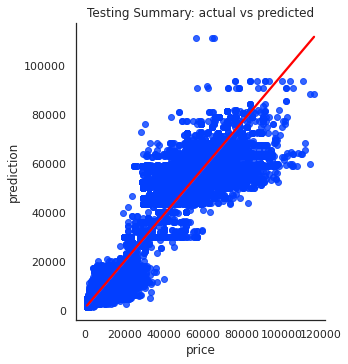

In [0]:
# From Spark to Pandas
pdf = dt_predictions.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt   #Data visualisation libraries 
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette("bright")


sns.lmplot(data=pdf, x='price', y='prediction', line_kws={'color': 'red'}, height=5, aspect=1).set(title='Testing Summary: actual vs predicted');

##Value of our model

Predicting flight prices in advance can give us monetary benefits by helping us make more informed decisions about when to book our flights. If we know that prices are likely to go up in the coming weeks or months, we can book our flights earlier to lock in a lower price. On the other hand, if prices are likely to go down, we can hold off on booking and wait for a better deal. In our case, we predicted that the ideal day to book an economy flight ticket would be around 20th day prior the day of travel.

## Tableau Visualisation


<div class='tableauPlaceholder' id='viz1682818835415' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;ProjectBDI&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ProjectBDI&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;ProjectBDI&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1682818835415');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.maxWidth='1250px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='2487px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.maxWidth='1250px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='2487px';} else { vizElement.style.width='100%';vizElement.style.height='1427px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>